<a href="https://colab.research.google.com/github/bythyag/machine-learning-projects/blob/main/fraud_detection_in_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# load libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.utils import resample
import seaborn as sns
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.metrics import f1_score, precision_score, recall_score

In [41]:
# load dataset

transactions = pd.read_csv('/Users/thyag/Desktop/codes/machine-learning-projects/dataset/fraud_detection.csv')

In [42]:
transactions.head()

,transaction_id,amount,merchant_type,device_type,label
0,1,46.93,travel,tablet,0
1,2,301.01,groceries,desktop,0
2,3,131.67,others,tablet,0
3,4,91.29,electronics,desktop,0
4,5,16.96,others,mobile,0


In [43]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


In [44]:
# Data Preprocessing

# For device_type
device_mapping = {
    'tablet': 0,
    'desktop': 1,
    'mobile': 2
}

# For merchant_type
merchant_mapping = {
    'travel': 0,
    'groceries': 1,
    'others': 2,
    'electronics': 3,
    'clothing': 4
}

transactions['device_type'] = transactions['device_type'].map(device_mapping)
transactions['merchant_type'] = transactions['merchant_type'].map(merchant_mapping)

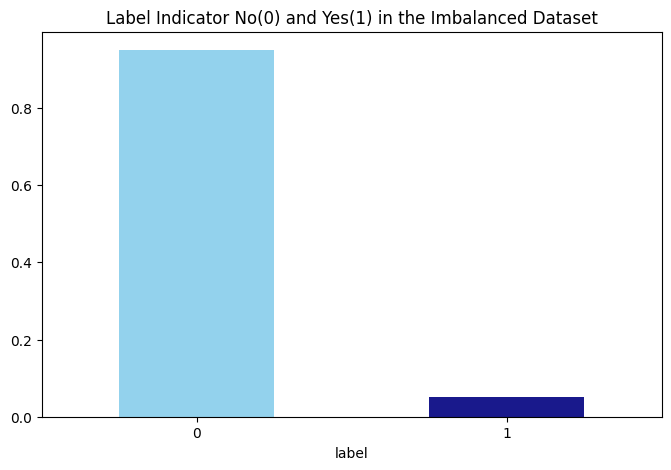

In [45]:
# explore label distribution

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
transactions.label.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Label Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

<Axes: >

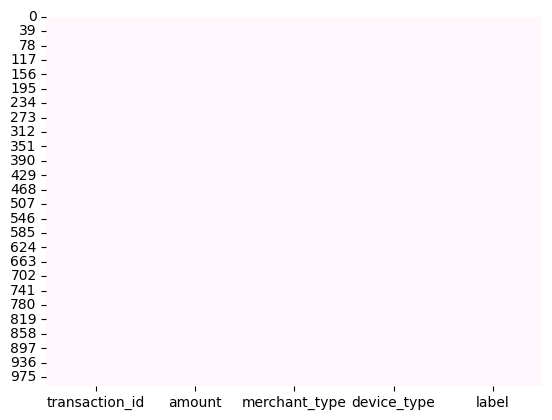

In [46]:
# check for missing values

sns.heatmap(transactions.isnull(), cbar=False, cmap='PuBu') #no missing values

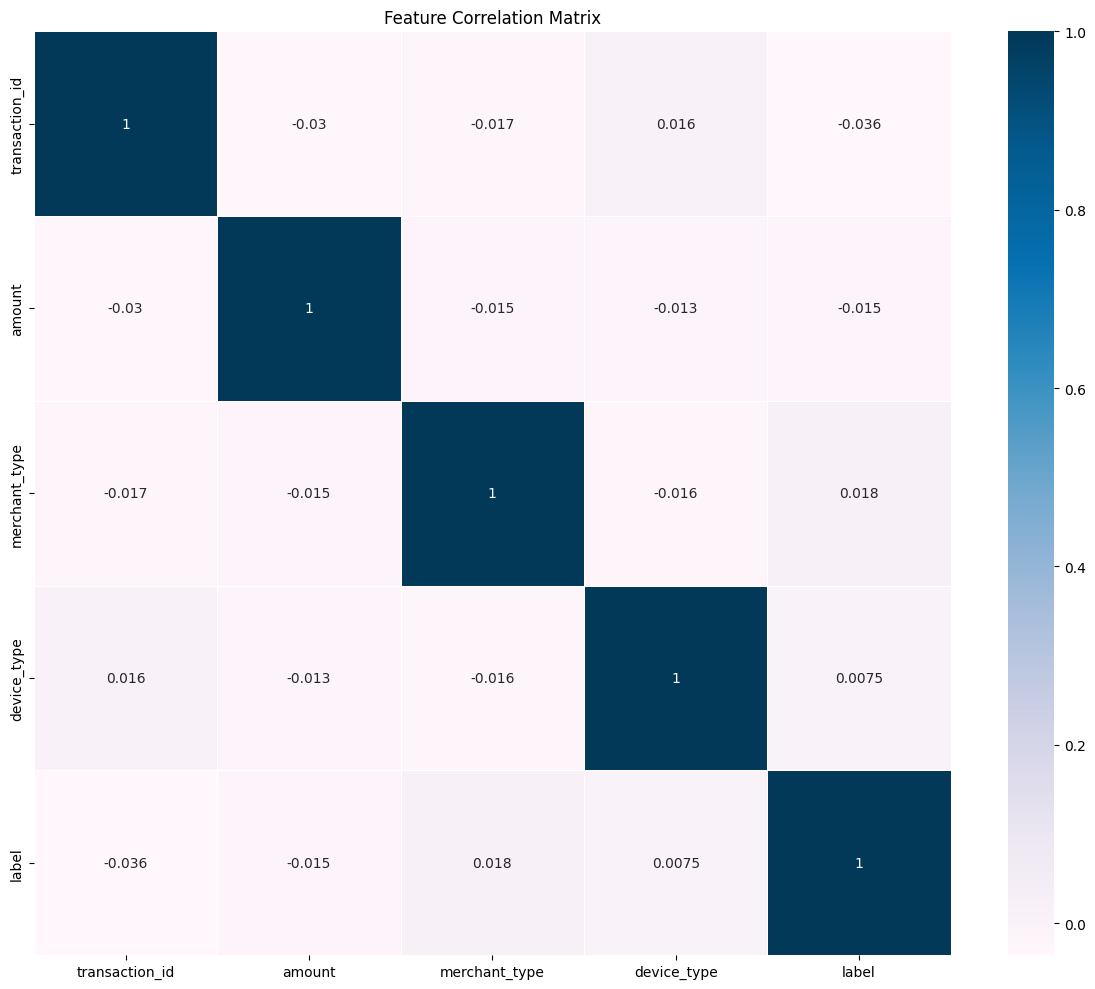

In [47]:
# correlation matrix

plt.figure(figsize=(12, 10))
correlation = transactions.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation, annot=True, cmap='PuBu', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [48]:

df_majority = transactions[transactions.label == 0]
df_minority = transactions[transactions.label == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,               # sample with replacement
    n_samples=len(df_majority), # match number of majority class
    random_state=42             # reproducibility
)

transactions = pd.concat([df_majority, df_minority_upsampled])

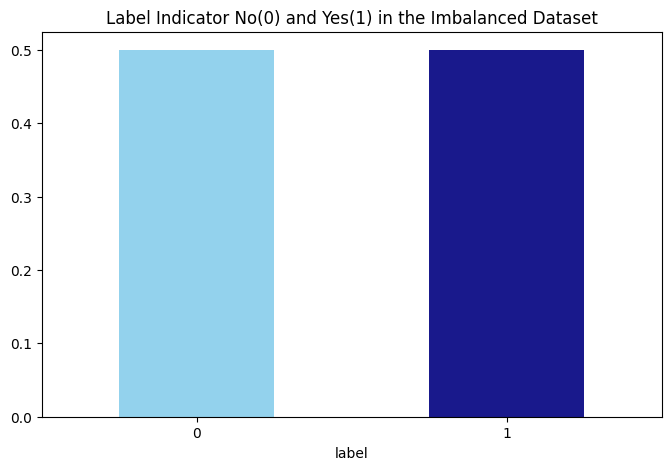

In [49]:
# explore label distribution

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
transactions.label.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Label Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [50]:
# Split dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(transactions.drop('label', axis=1), transactions['label'], test_size=0.2, random_state=42, shuffle=True, stratify=transactions['label'])

In [51]:
# Logistic Regression
from sklearn.preprocessing import StandardScaler

# Create a simple pipeline with Logistic Regression using default parameters
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='lbfgs', random_state=42))
])

# Train the model
pipeline_lr.fit(X_train, y_train)

# Predict on X_test
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluation metrics
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)

print("Logistic Regression Metrics:")
print("F1 Score:", f1_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)


Logistic Regression Metrics:
F1 Score: 0.5340314136125655
Precision: 0.53125
Recall: 0.5368421052631579


In [52]:
# Logistic Regression with GridSearchCV

# Create a pipeline with StandardScaler and Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs', 'liblinear']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the grid search on the training data
grid_search_lr.fit(X_train, y_train)

print("Best parameters:", grid_search_lr.best_params_)

# Predict on X_test using the best estimator
y_pred_lr = grid_search_lr.predict(X_test)

# Compute evaluation metrics
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)

print("Logistic Regression Metrics:")
print("F1 Score:", f1_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Logistic Regression Metrics:
F1 Score: 0.5340314136125655
Precision: 0.53125
Recall: 0.5368421052631579


In [53]:
# Random Forest Classifier with GridSearchCV

# Create a pipeline with StandardScaler and RandomForestClassifier
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the grid search on the training data
grid_search_rf.fit(X_train, y_train)

print("Best parameters for RandomForest:", grid_search_rf.best_params_)

# Predict on X_test using the best estimator
y_pred_rf = grid_search_rf.predict(X_test)

# Compute evaluation metrics
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)

print("Random Forest Metrics:")
print("F1 Score:", f1_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for RandomForest: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Random Forest Metrics:
F1 Score: 0.9973753280839895
Precision: 0.9947643979057592
Recall: 1.0


In [55]:
# XGBoost Classifier with GridSearchCV

# Create a pipeline with StandardScaler and XGBoostClassifier
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Define the parameter grid for GridSearchCV
param_grid_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the grid search on the training data
grid_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Predict on X_test using the best estimator
y_pred_xgb = grid_search_xgb.predict(X_test)

# Compute evaluation metrics
f1_xgb = f1_score(y_test, y_pred_xgb, zero_division=0)
precision_xgb = precision_score(y_test, y_pred_xgb, zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, zero_division=0)

print("XGBoost Metrics:")
print("F1 Score:", f1_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for XGBoost: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}
XGBoost Metrics:
F1 Score: 0.9743589743589743
Precision: 0.95
Recall: 1.0
